In [8]:
import torch
import os
import numpy as np
import pickle

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from LfH_main import sample, TrainingParams
from eval import  select_obstacles_and_check_collisions, filter_trajectories

from saad_utils import setup_timesteps_traj, quat_to_psi, rotate_origin_only

from render_demo_2D_mpi import generate_obstacle_trajectories, Params as RenderParams

In [ ]:
# VISUALIZING NEW RAW DATA
import matplotlib.pyplot as plt

# Data from the analysis
actions = ["Turned", "Straight", "Stopped", "Reversed"]

# Time spent on each action
time_spent = {
    "Turned": 186.43,
    "Straight": 51.17,
    "Stopped": 10.45,
    "Reversed": 11.56
}

# Total time
total_time = sum(time_spent.values())

# Count of each action
count_actions = {
    "Turned": 120,
    "Straight": 75,
    "Stopped": 30,
    "Reversed": 20
}

# Average duration per action
avg_duration = {action: time_spent[action] / count_actions[action] for action in actions}

# Maximum durations (replace with extracted max values)
max_duration = {
    "Turned": 7.74,
    "Straight": 2.25,
    "Stopped": 1.13,
    "Reversed": 0.85
}

# Pie Chart of Time Spent on Each Action
plt.figure(figsize=(8, 6))
plt.pie(time_spent.values(), labels=time_spent.keys(), autopct='%1.1f%%', colors=['blue', 'green', 'red', 'purple'])
plt.title("Percentage of Time Spent on Each Action")
plt.show()

# Bar Charts for Average, Maximum Duration, and Count of Each Action
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].bar(avg_duration.keys(), avg_duration.values(), color=['blue', 'green', 'red', 'purple'])
ax[0].set_title("Average Duration per Action")
ax[0].set_ylabel("Seconds")

ax[1].bar(max_duration.keys(), max_duration.values(), color=['blue', 'green', 'red', 'purple'])
ax[1].set_title("Maximum Duration per Action")
ax[1].set_ylabel("Seconds")

ax[2].bar(count_actions.keys(), count_actions.values(), color=['blue', 'green', 'red', 'purple'])
ax[2].set_title("Count of Each Action")
ax[2].set_ylabel("Count")

plt.tight_layout()
plt.show()


In [ ]:
# VISUALIZING NEW RAW DATA

import pickle
import math
import plotly.graph_objects as go

def quaternion_to_yaw(q):
    """Converts a quaternion (x, y, z, w) to a yaw angle in radians."""
    x, y, z, w = q
    siny_cosp = 2 * (w * z + x * y)
    cosy_cosp = 1 - 2 * (y * y + z * z)
    return math.atan2(siny_cosp, cosy_cosp)

def load_data(pickle_file):
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
    return data

def plot_data(data):
    # Create time vectors (using sample index as a proxy for time)
    n_odom = len(data["pos"])
    n_cmd = len(data["cmd_vel"])
    time_odom = list(range(n_odom))
    time_cmd = list(range(n_cmd))
    
    ## Chart 1: XY Positions with Orientation
    # Extract XY positions from odometry
    x_pos = [p[0] for p in data["pos"]]
    y_pos = [p[1] for p in data["pos"]]
    # Compute yaw (in radians) for each orientation quaternion
    yaw = [quaternion_to_yaw(o) for o in data["ori"]]
    
    # Define arrow endpoints (for orientation) using a fixed arrow length
    arrow_length = 0.2
    arrow_x = [x + arrow_length * math.cos(angle) for x, angle in zip(x_pos, yaw)]
    arrow_y = [y + arrow_length * math.sin(angle) for y, angle in zip(y_pos, yaw)]
    
    
    linear_cmd = data["cmd_vel"]
    angular_cmd = data["cmd_ang_vel"]
    
    reversing_indices = [i for i in range(n_cmd) if linear_cmd[i] < 0]
    stopping_indices = [i for i in range(n_cmd) if linear_cmd[i] == 0 and angular_cmd[i] == 0]
    
    # Markers for the states
    marker_colors = ['green' for _ in range(n_odom)]  # Default color for normal movement
    for i in reversing_indices:
        marker_colors[i] = 'yellow'  # yellow for reversing
    for i in stopping_indices:
        marker_colors[i] = 'red'  # red for stopping
    
    fig1 = go.Figure()
    # Plot the XY path with changing marker colors
    fig1.add_trace(go.Scatter(
        x=x_pos, 
        y=y_pos, 
        mode='markers', 
        name='Position',
        marker=dict(color=marker_colors, size=3)
    ))
    # Add orientation arrows at a subset of points to avoid clutter (e.g., every ~5% of data)
    # step = max(1, len(x_pos) // 20)
    # for i in range(0, len(x_pos), step):
        # fig1.add_annotation(
        #     x=arrow_x[i], y=arrow_y[i],
        #     ax=x_pos[i], ay=y_pos[i],
        #     xref="x", yref="y",
        #     showarrow=True,
        #     arrowhead=3,
        #     arrowsize=1,
        #     arrowwidth=1,
        #     arrowcolor="red"
        # )
    fig1.update_layout(
        title="Dyna_data: straight/reverse/stop/turn_left/turn_right",
        xaxis_title="X Position",
        yaxis_title="Y Position",
        showlegend=True,
        width=1000, height=1000,
        xaxis=dict(scaleanchor="y")  # Ensures a square aspect ratio
    )

    
    ## Chart 2: Odometry Velocities vs Time
    # From the odometry data, assume:
    # - Linear velocity: use the x-component (vel[0])
    # - Angular velocity: use the z-component (ang_vel[2])
    cmd_vel = data["cmd_vel"]
    cmd_ang_vel = data["cmd_ang_vel"]
    
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(x=time_cmd, y=cmd_vel, mode='lines', name='Command Linear Velocity'))
    fig2.update_layout(
        title="Command Linear Velocities vs Time",
        xaxis_title="Time (sample index)",
        yaxis_title="Velocity"
    )
    
    ## Chart 3: Command Velocities vs Time
    
    
    fig3 = go.Figure()
    fig3.add_trace(go.Scatter(x=time_cmd, y=cmd_ang_vel, mode='lines', name='Command Angular Velocity'))
    fig3.update_layout(
        title="Command Angular Velocity vs Time",
        xaxis_title="Time (sample index)",
        yaxis_title="Command Velocity"
    )
    
    # Display the plots in separate browser windows/tabs
    fig1.show()
    fig2.show()
    fig3.show()

pickle_file = "/projects/RobotiXX/saad/hallucination/data/2D/dyna_data3.p"
data = load_data(pickle_file)
plot_data(data)


In [9]:
# getting data from LfH_eval.p

#params:
eval_dir = "10obs_TS2+_lammr0_model_3090_drop_FIXED"

# end of params
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# code:

base_path = os.path.join("/scratch/sghani2/hallucination_new/LfH_eval/", eval_dir )
eval_path = os.path.join(base_path, "LfH_eval.p")

with open(eval_path, "rb") as f:
    eval_data = pickle.load(f)

for k in eval_data:
    print(k, eval_data[k][0].shape, "x", len(eval_data[k]))

obs_loc (1, 2) x 3741
obs_size (1, 2) x 3741
obs_time_idx (1, 34) x 3741
traj (2, 233, 2) x 3741
goal (233, 2) x 3741
raw_ori (233, 4) x 3741
raw_traj (2, 233, 3) x 3741
recon_traj (1, 2, 233, 2) x 3741
final_recon_losses () x 3741
cmd (2, 233) x 3741


In [10]:
# DISTRIBUTION OF CRITICAL POINTS
time_idxs = eval_data["obs_time_idx"]
num_trajs = len(time_idxs)
num_max_obs = 10
num_critical_points = time_idxs[0].shape[-1]
obs_locs_eval = eval_data["obs_loc"]

# robot_trajs = np.array(eval_data["traj"])
# robot_oris = np.array(eval_data["raw_ori"])

# robot_psis = quat_to_psi(robot_oris)
# robot_psis = robot_psis[:] - robot_psis[:, [0]]

# setup_timesteps_traj(-3, 35)

all_obs = []
all_time_idx = []
for i in range(0,num_trajs):
    all_time_idx.extend(time_idxs[i].nonzero()[1])
    all_obs.extend(obs_locs_eval[i])

all_obs, all_time_idx = np.array(all_obs), np.array(all_time_idx)
all_obs[:,1] *= -1

# print(robot_psis.shape, robot_trajs.shape)

In [12]:
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

# Path to Times New Roman TTF file
ttf_path = "/home/sghani2/times.ttf"  # update with actual path

# Load the font
label_tnr = fm.FontProperties(fname=ttf_path, size=18)
legend_tnr = fm.FontProperties(fname=ttf_path, size=14)
title_tnr = fm.FontProperties(fname=ttf_path, size=24)


[[52.5  35.    5.   30.83]
 [32.5  25.   10.   22.5 ]]


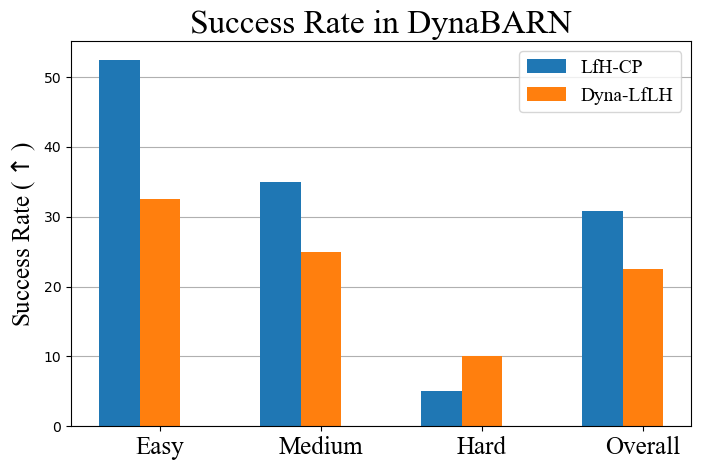

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Data
methods = ['LfH-CP', 'Dyna-LfLH']
categories = ['Easy', 'Medium', 'Hard', 'Overall']
successes = np.array([[21, 14, 2],
                      [13, 10, 4]])


successes = successes / 40
successes = np.concatenate((successes, np.array([[0.3083, 0.225]]).T),axis=1)
successes = successes * 100
print(successes)
# Bar chart setup
x = np.arange(len(categories))
width = 0.25

fig, ax = plt.subplots(figsize=(8,5))
ax.set_axisbelow(True)
ax.yaxis.grid(True)
for i, method in enumerate(methods):
    ax.bar(x + i*width, successes[i], width, label=method)

ax.set_xticks(x + width)
ax.set_xticklabels(categories, fontproperties=label_tnr)
ax.set_ylabel(r'Success Rate ($\uparrow$)', fontproperties=label_tnr)
ax.set_title('Success Rate in DynaBARN', fontproperties=title_tnr)
ax.legend(prop=legend_tnr)


plt.savefig("sim_results.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (3,).

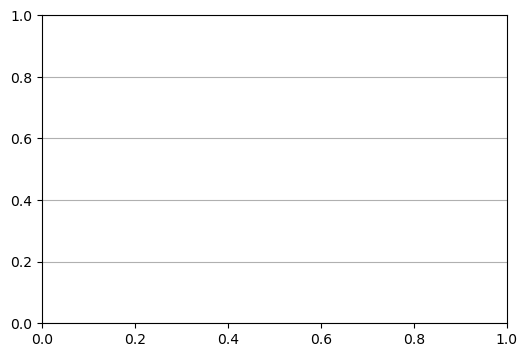

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Data
methods = ['LfH-CP', 'Dyna-LfLH']
successes = np.array([[19, 22, 5],
                      [21, 14, 2],
                      [13, 10, 4]])

totals = successes.sum(axis=1) /120

colors = ['tab:blue', 'tab:orange']  # one per method

fig, ax = plt.subplots(figsize=(6,4))
ax.set_axisbelow(True)
ax.yaxis.grid(True)

x = np.arange(len(methods))
ax.bar(x, totals, width=0.5, color=colors)

ax.set_xticks(x)
ax.set_xticklabels(methods, fontproperties=label_tnr)
ax.set_ylabel('Success Rate (%)', fontproperties=label_tnr)
ax.set_title('Overall Success Rate in DynaBARN', fontproperties=title_tnr)

plt.savefig("sim_results_total_colored.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()


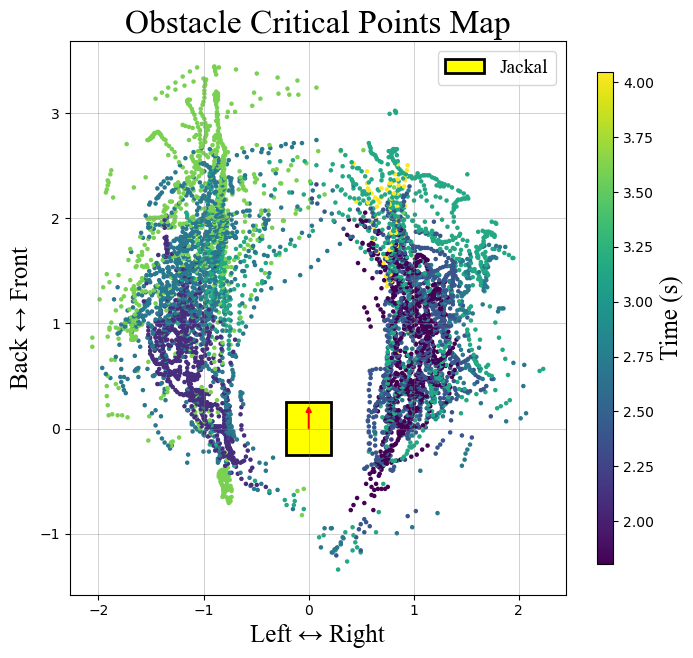

In [12]:
import numpy as np
import matplotlib.pyplot as plt

knot_start = -3
knot_end = 35
knot_dt = 0.15
reference_pt_timestamp = np.arange(knot_start + 2, knot_end - 2)
reference_pt_timestamp = reference_pt_timestamp * knot_dt
all_time = reference_pt_timestamp[all_time_idx]

# Histogram
joined_data = np.concatenate((all_obs, all_time.reshape(-1, 1)), axis=1)
hist, edges = np.histogramdd(joined_data, bins=500)

# Prepare arrays for scatter plot
x_flat, y_flat, time_flat = [], [], []

for i in range(hist.shape[0]):
    for j in range(hist.shape[1]):
        counts_in_bin = hist[i, j, :]
        if counts_in_bin.sum() > 0:
            x_flat.append((edges[0][i] + edges[0][i+1]) / 2)
            y_flat.append((edges[1][j] + edges[1][j+1]) / 2)
            z_centers = (edges[2][:-1] + edges[2][1:]) / 2
            avg_time = np.sum(z_centers * counts_in_bin) / counts_in_bin.sum()
            time_flat.append(avg_time)

x_flat, y_flat, time_flat = np.array(x_flat), np.array(y_flat), np.array(time_flat)

# --- Plot with matplotlib ---
fig, ax = plt.subplots(figsize=(8, 8))

# Scatter plot of histogram bins
sc = ax.scatter(
    -y_flat, x_flat, c=time_flat, s=5
)

# radius = 0.5  # adjust size of circles
# for x, y in zip(-y_flat, x_flat):
#     circle = plt.Circle((x, y), radius, color='black', fill=False, linestyle=':', alpha=0.1, linewidth=0.1)
#     ax.add_patch(circle)
# proxy_circle = plt.Circle((0,0), radius, edgecolor='black', facecolor='none', linestyle=':', alpha=0.8, linewidth=0.2)


# Jackal dimensions (m)
length = 0.508
width = 0.430
# Rectangle corners (centered at 0,0)
x_rect = [-width/2, width/2, width/2, -width/2, -width/2]
y_rect = [-length/2, -length/2, length/2, length/2, -length/2]
# Fill Jackal body
jackal_patch = ax.fill(x_rect, y_rect, facecolor="yellow", edgecolor="black", linewidth=2, label="Jackal")
jackal_patch = jackal_patch[0]

# Orientation arrow
ax.arrow(0, 0, 0, length/2 - 0.1, color="red", width=0.005, head_width=0.05, head_length=0.05)

# Axis labels & formatting
ax.set_xlabel("Left ↔ Right", fontproperties=label_tnr)
ax.set_ylabel("Back ↔ Front", fontproperties=label_tnr)
ax.set_title("Obstacle Critical Points Map", fontproperties=title_tnr)

# Colorbar
cbar = plt.colorbar(sc, ax=ax, aspect=30, shrink=0.8)
cbar.set_label("Time (s)", fontproperties=label_tnr)

ax.set_aspect("equal", adjustable="box")
ax.legend([jackal_patch], ["Jackal", ], prop=legend_tnr)
ax.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5)


fig.savefig("obstacle_cps_map.pdf", format="pdf", dpi=300, bbox_inches="tight")


plt.show()


In [ ]:
# EXAMPLE TRAJECTORIES 
obs_locs = eval_data["obs_loc"]
obs_time = eval_data["obs_time_idx"]

num_obs = np.array(([l.shape[0] for l in obs_locs]))

obs_5 = num_obs == 4
idxs_5 = np.where(obs_5)[0]

trajs = np.array(eval_data["traj"])[:, 0]

trajs_5 = trajs[obs_5]

fig = make_subplots(rows=2, cols=3)

colors = ["red", "green", "blue", "purple", "yellow"]

for i in range(min(trajs_5.shape[0], 6)):
    obs_5_locs = obs_locs[idxs_5[i]]
    print(np.where(obs_time[idxs_5[i]]))
    for j, xy in enumerate(obs_5_locs):
        fig.add_shape(type="circle", x0=xy[0]-0.25,x1=xy[0]+0.25, y0=xy[1]-0.25,y1=xy[1]+0.25,row=i//3+1, col=i%3+1, fillcolor=colors[j])

    fig.add_scatter(x=trajs_5[i, :, 0], y=trajs_5[i, :,1], row=i//3 +1, col=i%3 +1, showlegend=False)

fig.update_layout(
    xaxis=dict(scaleanchor="y"),
    yaxis=dict(scaleanchor="x"),
    xaxis2=dict(scaleanchor="y"),
    yaxis2=dict(scaleanchor="x"),
    xaxis3=dict(scaleanchor="y"),
    yaxis3=dict(scaleanchor="x"),
    height=600, width=900)
fig.show()





In [ ]:
trajs = np.array(eval_data["traj"])[:, 0]
final_recon_losses = np.array(eval_data["final_recon_losses"])
traj_len = trajs.shape[1]

min_loss_thresh = 5
perc_thresh = 0.1


init_control_pts = trajs[:, None, 0] + \
                           np.linspace(0, 1, traj_len)[None, :, None] * \
                           (trajs[:, None, -1] - trajs[:, None, 0])
straight_line_recon_loss = np.sum((init_control_pts - trajs)**2, axis=(1,2)) 


lessthan_perc_thresh = final_recon_losses/straight_line_recon_loss <= perc_thresh
lessthan_min = final_recon_losses < min_loss_thresh
only_lessthanmin = (lessthan_min & ~lessthan_perc_thresh)
only_lessthanperc = (~lessthan_min & lessthan_perc_thresh)

lessthan_both = lessthan_min & lessthan_perc_thresh
lessthan_all = lessthan_min | lessthan_perc_thresh

print(only_lessthanperc.sum(), lessthan_both.sum(), only_lessthanmin.sum(), lessthan_all.sum())

In [ ]:

mask = np.zeros_like(final_recon_losses, dtype=bool)  # Create a mask with the same shape
mask[lessthan_min] = (final_recon_losses[lessthan_min] / straight_line_recon_loss[lessthan_min]) > 1


worsethan_perc_thresh = final_recon_losses/straight_line_recon_loss > perc_thresh
worsethan_min = final_recon_losses > min_loss_thresh
worsethan_min[mask] = True


(worsethan_perc_thresh & worsethan_min).sum()

In [ ]:
trajs = np.array(eval_data["traj"])[:, 0]
recon_trajs = np.array(eval_data["recon_traj"])[:, 0, 0]

frl_low = (final_recon_losses < min_loss_thresh) 

loss_recon_worse = ((final_recon_losses[frl_low] / straight_line_recon_loss[frl_low]) > 1)
print(loss_recon_worse.sum())

bad_trajs = trajs[frl_low][loss_recon_worse]
bad_recons = recon_trajs[frl_low][loss_recon_worse]
bad_straights = init_control_pts[frl_low][loss_recon_worse]

idx = 5

fig = go.Figure()
fig.add_scatter(x=bad_trajs[idx,:,0], y=bad_trajs[idx,:,1], name="traj")
fig.add_scatter(x=bad_recons[idx,:,0], y=bad_recons[idx,:,1], name="recon")
fig.add_scatter(x=bad_straights[idx,:,0], y=bad_straights[idx,:,1], mode="markers", name="straight_ctrl_pts")
fig.show()


In [ ]:
new_eval_idxs = np.concatenate((np.where(less_than)[0], np.where((final_recon_losses < 1) & ~less_than)[0]))

new_eval = {}
for k in eval_data:
    new_eval[k] = []
    for idx in new_eval_idxs:
        new_eval[k].append(eval_data[k][idx])


In [ ]:
eval_traj = np.stack(eval_data["traj"], axis=0)[np.where(lessthan_all)[0], 0]

fig = go.Figure()
for i in range(len(eval_traj)):
    fig.add_scatter(x=-eval_traj[i, :, 1], y=eval_traj[i,:,0], showlegend=False, opacity=0.1, line_color="blue")
fig.show()

In [ ]:
def velocity_to_euclidean_vector(v,w,theta, dt=0.1):
    theta_new = theta + w * dt  # Update heading based on angular velocity
    x_vec = v * np.cos(theta_new)
    y_vec = v * np.sin(theta_new)
    return x_vec, y_vec


def calculate_correct_goal(traj, raw_ori):
    psis = quat_to_psi(raw_ori.reshape(-1, 4)).reshape(-1, 233)
    psi_diff_ = psis - psis[:, [0]]                                                                  # the difference between psi @ robot position and psi @ traj start

    calculated_goals = traj[:,0, [-1], :2] - traj[:,0, :, :2]       
    calculated_goals = rotate_origin_only(calculated_goals, psi_diff_)                                                               # goal in robocentric frame. rotate around every single point using the diff. this will get the goal in 
    calculated_goals = calculated_goals / (np.linalg.norm(calculated_goals, axis=-1, keepdims=True)+1e-9)
    
    return calculated_goals

traj = np.array(eval_data["traj"])
cmds = np.array(eval_data["cmd"])
raw_oris = np.array(eval_data["raw_ori"])

goals = calculate_correct_goal(traj, raw_oris)


x_, y_ = velocity_to_euclidean_vector(cmds[:, 0], cmds[:, 1], 0)
cmd_euclidean = np.stack((x_, y_), axis=-1) 

cosine_diff = (cmd_euclidean * goals).sum(-1) / (np.linalg.norm(cmd_euclidean, axis=-1)* np.linalg.norm(goals, axis=-1) + 1e-9)
cosine_diff.shape

fig = make_subplots(2, 1)
fig.add_scatter(y=cosine_diff[0], x = np.arange(cosine_diff.shape[1]), row=1, col=1)
fig.add_scatter(x=traj[0,0,:,0], y=traj[0,0,:,1], row=2, col=1)
fig.show()

In [ ]:


eval_traj = np.stack(eval_data["traj"], axis=0)[np.where(less_than)[0], 0]

rows = 10
cols = 15
fig = make_subplots(rows, cols, shared_xaxes=True, shared_yaxes=True)
for i in range(min(eval_traj[::5].shape[0], 150)):
    fig.add_scatter(x=eval_traj[i, :,0], y=eval_traj[i, :,1], row=i//cols+1, col=i%cols+1)

fig.update_layout(width=2000, height=1500)
fig.show()

In [ ]:
# GETTING DATA DIRECTLY FROM MODEL

#params:
model_dir = "10obs_TS2+_lammr0_model_3090_drop_FIXED"
model_cps = ["model"]
training_stages = [2]
num_samples = 25
# end of params
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# code:

def get_straight_line(_trajs_pos):
    _traj_len = _trajs_pos.shape[-2]
    _init_control_pts = _trajs_pos[:, None, 0] + \
                           np.linspace(0, 1, _traj_len)[None, :, None] * \
                           (_trajs_pos[:, None, -1] - _trajs_pos[:, None, 0])
    
    _straight_line_recon_loss = np.sum((_init_control_pts - _trajs_pos)**2, axis=(1,2)) 

    return _init_control_pts, _straight_line_recon_loss

all_results = {1:{}, 2:{}}
base_path = os.path.join("/projects/RobotiXX/saad/hallucination/rslts/LfH_rslts", model_dir)
for i, cp in enumerate(model_cps):
    model_path = os.path.join(base_path, cp)
    params_path = os.path.join(base_path, "params.json") 

    params=TrainingParams(params_path, train=False)
    params.model_params.gumbel_starting_tau = 0.1
    params.model_params.lambda_time_idx_entropy = 0.5

    dict_out = sample(params, model_path, n_times=num_samples, training_stage=training_stages[i], seed=100)
    dict_out["training_stage"] = training_stages[i]
    all_results[training_stages[i]].update(dict_out)
    all_results[training_stages[i]]["params"] = params
    # dict_out.keys()

In [ ]:
for k in all_results.keys():
    dict_out = all_results[k]
    min_obs = 1
    max_obs = 7
    thresh = 1
    locs = dict_out["loc"]
    sizes = dict_out["size"]
    time_idxs = dict_out["time_idx"]
    model = dict_out["model"]
    reference_pts = dict_out["reference_pts"]
    traj_tensor = dict_out["traj"]
    params = dict_out["params"]

    selected_obs, stats, in_collision = [], [], []
    for sample_i in range(num_samples):
        sel_obs, stats_, collision = select_obstacles_and_check_collisions(locs[sample_i], sizes[sample_i],  time_idxs[sample_i], reference_pts[sample_i], traj_tensor[sample_i], model, params)
        # sel_obs, stats_ = feature_selection(min_obs, max_obs, thresh, locs[sample_i], sizes[sample_i], time_idxs[sample_i], reference_pts[sample_i], model, traj_tensor[sample_i], forward_feat=True)
        selected_obs.append(sel_obs)
        stats.append(stats_)
        in_collision.append(collision)

    trajs = traj_tensor.detach().cpu().numpy()

    rejected_trajs = filter_trajectories(trajs, stats, params)
    # combine accepted_trajs and collision_list
    collision_or_rejected = np.array(in_collision) | rejected_trajs
    recon_trajs = np.array([stat["recon_traj"] for stat in stats])
    final_recon_losses = np.array([stat["loss"][-1] for stat in stats])

    not_rejected = np.where(~collision_or_rejected)[0]

    good_recon_trajs, good_recon_losses, good_trajs = recon_trajs[not_rejected], final_recon_losses[not_rejected], trajs[not_rejected]
    print(f"training stage {k}")
    # print(not_rejected, good_recon_losses)
    print("-"*100)

    dict_out["not_rejected_idx"] = not_rejected
    dict_out["good_recon_losses"] = good_recon_losses
    dict_out["good_recon_trajs"] = good_recon_trajs
    dict_out["good_trajs"] = good_trajs
    straight_line_traj, straight_line_loss = get_straight_line(good_trajs[:, 0])
    dict_out["straight_line_traj"] = straight_line_traj
    dict_out["straight_line_loss"] = straight_line_loss
   
    # break

In [ ]:
# calculate the difference between the static recon loss and cp recon loss
_, idx_common1, idx_common2 = np.intersect1d(all_results[1]["not_rejected_idx"] , all_results[2]["not_rejected_idx"], assume_unique=True, return_indices=True)

recon_loss1 = all_results[1]["good_recon_losses"][idx_common1]
recon_loss2 = all_results[2]["good_recon_losses"][idx_common2]


from scipy import stats
import numpy as np


t_stat, p_value = stats.ttest_rel(recon_loss1, recon_loss2)

diff = recon_loss1 - recon_loss2
mean_diff = np.mean(diff)
std_diff = np.std(diff, ddof=1)  # sample std

print("mean:",mean_diff) 
print("std_dev:",std_diff)

alpha = 0.05
if p_value < alpha:
    print(f"Reject null hypothesis (p={p_value:.5f})")
else:
    print(f"Fail to reject null hypothesis (p={p_value:.5f})")


In [ ]:
# visualize the traj vs recon(static) vs recon (cp)
import matplotlib.pyplot as plt
import numpy as np
import math

_, idx_common1, idx_common2 = np.intersect1d(all_results[1]["not_rejected_idx"] , all_results[2]["not_rejected_idx"], assume_unique=True, return_indices=True)

recon1 = all_results[1]["good_recon_trajs"][idx_common1][:, 0, 0]
recon2 = all_results[2]["good_recon_trajs"][idx_common2][:, 0, 0]

recon_loss1 = all_results[1]["good_recon_losses"][idx_common1]
recon_loss2 = all_results[2]["good_recon_losses"][idx_common2]

og_traj = all_results[1]["good_trajs"][idx_common1][:, 0]

manually_selected_idxs = [1,2,23,69]

recon1, recon2, recon_loss1, recon_loss2, og_traj = \
    recon1[manually_selected_idxs], recon2[manually_selected_idxs], recon_loss1[manually_selected_idxs], recon_loss2[manually_selected_idxs], og_traj[manually_selected_idxs]

def plot_all_trajectories(all_recon1, all_recon2, all_og, recon1_losses, recon2_losses, pad=0.01):
    """
    all_recon1, all_recon2, all_og: list of arrays (len = 76). Each array shape (N, 2).
    recon1_losses, recon2_losses: list of floats (len = 76).
    pad: fraction of span to pad around min/max
    """
    import matplotlib.pyplot as plt
    from matplotlib import font_manager as fm

    # Path to Times New Roman TTF file
    ttf_path = "/home/sghani2/times.ttf"  # update with actual path

    # Load the font
    label_tnr = fm.FontProperties(fname=ttf_path, size=18)
    legend_tnr = fm.FontProperties(fname=ttf_path, size=18)

    n = len(all_recon1)
    cols = 2
    rows = math.ceil(n / cols)

    colors = {
        "recon1": "tab:blue",
        "recon2": "tab:orange",
        "og": "tab:green"
    }

    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = axes.flatten()

    for i in range(n):
        ax = axes[i]

        x_data = np.concatenate([all_recon1[i][:,0], all_recon2[i][:,0], all_og[i][:,0]])
        y_data = np.concatenate([all_recon1[i][:,1], all_recon2[i][:,1], all_og[i][:,1]])

        # Plot
        ax.plot(all_recon1[i][:, 0], all_recon1[i][:, 1], color=colors["recon1"], linewidth=1.5)
        ax.plot(all_recon2[i][:, 0], all_recon2[i][:, 1], color=colors["recon2"], linewidth=1.5)
        ax.plot(all_og[i][:, 0], all_og[i][:, 1], color=colors["og"], linewidth=1.5, linestyle="--")

        # Loss text
        loss_text = f"P1 Loss: {recon1_losses[i]:.3f}\nP2 Loss: {recon2_losses[i]:.3f}"
        ax.text(0.02, 0.98, loss_text,
                transform=ax.transAxes,
                ha="left", va="top", 
                fontproperties=label_tnr)
                # bbox=dict(boxstyle="round", facecolor="white", alpha=0.8, edgecolor="none"))

        # Axis scaling with padding and equal scale
        x_min, x_max = x_data.min(), x_data.max()
        y_min, y_max = y_data.min(), y_data.max()
        x_span = x_max - x_min
        y_span = y_max - y_min

        span = max(x_span, y_span)
        x_center = 0.5 * (x_max + x_min)
        y_center = 0.5 * (y_max + y_min)

        span *= (1 + pad)  # add padding
        ax.set_xlim(x_center - span/2, x_center + span/2)
        ax.set_ylim(y_center - span/2, y_center + span/2)

        ax.set_aspect("equal", adjustable="box")
        ax.grid(True, linestyle="--", alpha=0.3)
        ax.set_xticks([])
        ax.set_yticks([])
        # ax.set_title(f"Traj {i}", fontsize=9)

    # Remove unused axes
    for j in range(n, len(axes)):
        fig.delaxes(axes[j])

    handles = [
        plt.Line2D([], [], color=colors["recon1"], label="Phase 1 Recon. Traj."),
        plt.Line2D([], [], color=colors["recon2"], label="Phase 2 Recon. Traj."),
        plt.Line2D([], [], color=colors["og"], linestyle="--", label="Original Traj.")
    ]
    fig.legend(handles=handles, loc="upper center", ncol=2, prop=legend_tnr, bbox_to_anchor=(0.5, -0.02))

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    return fig

fig = plot_all_trajectories(recon1, recon2, og_traj, recon_loss1, recon_loss2)
fig.show()


In [ ]:
fig.savefig("recon_trajs.pdf", format="pdf", dpi=600, bbox_inches="tight")

In [ ]:
render_params = RenderParams()
render_params.S_samples = 5
render_params.clearance_scale = 1.0
render_params.min_valid_samples_per_obs = 2

max_sel_obs = max([len(x_) for x_ in selected_obs])
num_obs = locs.shape[1]
next_sample_at = 0
all_configs = np.ones((num_samples * 5**max_sel_obs, num_obs, 233, 2)) * 1e+10

traj_idxs = []
for sample_i in range(1):
    locs_ = locs[sample_i, selected_obs[sample_i]].detach().numpy()
    time_idxs_ = time_idxs[sample_i, selected_obs[sample_i]].detach().numpy()
    traj_ = traj_tensor[sample_i].detach().numpy()
    gen_obs_trajs = generate_obstacle_trajectories(locs_, time_idxs_, traj_, render_params, sample_i)
    
    sample_size = gen_obs_trajs.shape[0]
    obs_index = selected_obs[sample_i]
    all_configs[next_sample_at: next_sample_at+ sample_size, obs_index] = gen_obs_trajs
    next_sample_at = next_sample_at + sample_size

#     traj_idxs.extend([sample_i]*sample_size)
# all_configs = all_configs[:next_sample_at]

# all_configs = np.concatenate(all_configs, axis=0)
# print(all_configs.shape)

In [ ]:
y_top = 0.165
y_bottom = -0.165
x_right = 0.21
x_left = -0.21
n = 10
boundary = np.zeros((4 * n, 2))
xx = np.linspace(x_left, x_right, n)
yy = np.linspace(y_bottom, y_top, n)
# order is U, B, L, R
boundary[:n][:, 0] = xx
boundary[n:2 * n][:, 0] = xx
boundary[2 * n:3 * n][:, 0] = x_left
boundary[3 * n:][:, 0] = x_right
boundary[:n][:, 1] = y_top
boundary[n:2 * n][:, 1] = y_bottom
boundary[2 * n:3 * n][:, 1] = yy
boundary[3 * n:][:, 1] = yy


raw_traj = dict_out["raw_traj"][:, 0].detach().numpy()
x = raw_traj[1:, -4:, 0].flatten()
x = np.concatenate((raw_traj[0, :-4, 0], x))
y = raw_traj[1:, -4:, 1].flatten()
y = np.concatenate((raw_traj[0, :-4, 1], y))

# recons = dict_out["recon_traj"] 
# cmd_eval = eval_data["cmd"][::eval_sample_per_traj]
traj = traj_[0][None] #traj_tensor[:, 0].detach().numpy() #dict_out["traj"][:, 0].detach().numpy()
recon_traj = recon_trajs[0, 0][None]#.detach().numpy() # dict_out["recon_traj"][:, 0].detach().numpy() #eval_data["recon_traj"][::eval_sample_per_traj][:, 0] if len(eval_data["recon_traj"]) > 0 else None

# orientation
raw_ori = dict_out["raw_ori"].detach().numpy() #eval_data["raw_ori"][::eval_sample_per_traj]
deg_psi = -quat_to_psi(raw_ori)*180/np.pi + 90
psi = deg_psi[1:, -4:].flatten()
psi = np.concatenate((deg_psi[0, :-4], psi))

# # laser and goals
# num_hallucinations = traj.shape[0] 
# L_seq = int(np.floor((106/50 - seq_len/lidar_freq)*cmd_freq)+1)
# skip = eval_sample_per_traj * render_sample_per_traj * L_seq

obs_loc = dict_out["loc"].detach().numpy() #eval_data["obs_loc"][::eval_sample_per_traj]
obs_time_idx = dict_out["time_idx"].detach().numpy() # eval_data["obs_vel"][::eval_sample_per_traj]

thetas = np.linspace(0, 2*np.pi, 360)
obs_xx, obs_yy = np.cos(thetas)*0.5, np.sin(thetas)*0.5

# taking time into consideration
# time_idx = dict_out["time_idx"].detach().numpy()


fulltraj_ref_pt_idx, traj_ts, fulltraj_ts, fulltraj_ref_pt_ts = setup_timesteps_traj(-3, 35)
traj_ref_pt_idxs = fulltraj_ref_pt_idx[1: -1]
# traj_time_idxs = time_idx[..., 1:-1]

obs_vel = dict_out["vel"].detach().numpy()


# num_samples, num_obs, num_ft_ctrl_pts = time_idx.shape
# fulltraj_ref_pt_ts_tiled = np.tile(fulltraj_ref_pt_ts, (num_samples, num_obs, 1))
# time_bool = time_idx.astype(bool)
# t0 = fulltraj_ref_pt_ts_tiled[time_bool]

# adjusted_timesteps = fulltraj_ref_pt_ts_tiled - t0.reshape(num_samples, num_obs, 1)


In [ ]:
# without goal and lasers


test_obs_evolved =  gen_obs_trajs[:,:, traj_ref_pt_idxs] #evolved[0, nocollisions, 1][:, None]
num_effective_samples = len(test_obs_evolved)


visualize_training_stage = 3

idxs = [0]*num_effective_samples #np.random.choice(np.arange(len(traj)), 10) #np.arange(len(traj)) 
# obs_idx = [1]

obs_colors = ["red", "blue", "darkgreen", "purple", "pink", "orange", "cyan", "black", "grey", "lightgreen"]

num_ctrl_pts = len(traj_ref_pt_idxs)




# if visualize_training_stage == 3:
#     test_obs_evolved = obs_loc[idxs][:, :, None] + obs_vel[idxs][:, :, None] * adjusted_timesteps[idxs][..., None]
#     test_obs_evolved = test_obs_evolved[:, :, 1:-1]
# else:
#     test_obs_evolved = np.repeat(obs_loc[idxs][:, obs_idx, None], num_ctrl_pts, axis=2)  #+ obs_vel[idxs][:, :, None] * timesteps_traj[None, None, :, None]



test_traj = traj[:, traj_ref_pt_idxs][idxs]
test_recon_traj = recon_traj[:, traj_ref_pt_idxs][idxs] # if recon_traj is not None else None



num_obs = test_obs_evolved.shape[1]
# test_obs_evolved = test_obs_evolved
test_obs_x = test_obs_evolved[:, :, :, None, 0] + obs_xx[None, None] 
test_obs_y = test_obs_evolved[:, :, :, None, 1] + obs_yy[None, None]

test_scan_psi = quat_to_psi(raw_ori)[idxs][:, traj_ref_pt_idxs]
test_scan_psi = test_scan_psi - test_scan_psi[:, [0]]
test_scan_psi_0 = test_scan_psi[:, 0]

temp_obs__ = np.stack((test_obs_x, test_obs_y), axis=-1)
test_obs_x_all = []
test_obs_y_all = []
for i in range(len(test_scan_psi_0)):
    test_obs_ = temp_obs__[i] #rotate_origin_only(temp_obs__[i], -test_scan_psi_0[i])
    test_obs_x, test_obs_y = test_obs_[..., 0], test_obs_[..., 1]
    test_obs_x += test_traj[i, 0, 0]
    test_obs_y += test_traj[i, 0, 1]
    test_obs_x_all.append(test_obs_x)
    test_obs_y_all.append(test_obs_y)
test_obs_x = np.array(test_obs_x_all)
test_obs_y = np.array(test_obs_y_all)

all_boundaries = []
for i, test_scan_psi_ in enumerate(test_scan_psi):
    R_r2i = []
    for psi in test_scan_psi_:
        R_r2i.append(np.array([np.cos(psi), -np.sin(psi), np.sin(psi), np.cos(psi)]).reshape(2, 2))  # [B, 2, 2]
    R_r2i = np.array(R_r2i)
    N = boundary.shape[0]
    rotation = np.matmul(R_r2i.reshape(-1, 1, 2, 2), boundary.reshape(1, -1, 2, 1)).reshape(-1, N, 2)  # [B, N, 2]
    test_boundaries = rotation + test_traj[i, :, None, :2]
    all_boundaries.append(test_boundaries)
all_boundaries = np.array(all_boundaries)

if test_recon_traj is not None:
    test_recon_traj_ = []
    for i in range(len(test_scan_psi_0)):
        t_ = test_recon_traj[i] #rotate_origin_only(test_recon_traj[i], test_scan_psi_0[i])
        t_[..., 0] += test_traj[i, 0, 0]
        t_[..., 1] += test_traj[i, 0, 1]
        test_recon_traj_.append(t_)
    test_recon_traj = np.array(test_recon_traj_)

all_frames = []
for loop_i in range(all_boundaries.shape[0] * all_boundaries.shape[1]):
    i = loop_i % all_boundaries.shape[1]
    j = loop_i // all_boundaries.shape[1]

    
    data_for_one_frame = []
    for obs_k, (obs_x, obs_y) in enumerate(zip(test_obs_x[j], test_obs_y[j])):
        if visualize_training_stage == 2:
            is_obs_visible = traj_time_idxs[j, obs_k, i]
            data_for_one_frame.append(go.Scatter(x=obs_x[i], y=obs_y[i], mode="lines", fill="toself", showlegend=False, visible=is_obs_visible>0.5, ))
        else:
            data_for_one_frame.append(go.Scatter(x=obs_x[i], y=obs_y[i], mode="lines", fill="toself", showlegend=False))

    data_for_one_frame.append(go.Scatter(x=all_boundaries[j, i, :, 0], y=all_boundaries[j, i, :, 1], mode="lines", opacity=1.0, line_color="black", fill="toself", name="Jackal"))
    
    data_for_one_frame.append(go.Scatter(x=test_traj[j, :, 0].flatten(), y=test_traj[j, :, 1].flatten(), line_color="limegreen", mode="markers", opacity=0.75, marker_size=5, name="Jackal Trajectory<br>in Open Space"))
    data_for_one_frame.append(go.Scatter(x=test_recon_traj[j, :, 0].flatten(), y=test_recon_traj[j, :, 1].flatten(), line_color="red", mode="markers", opacity=0.5, marker_size=5, name="Recon Traj"))

    
    
    xmin = test_traj[j, i, 0] - 7.5
    xmax = test_traj[j, i, 0] + 7.5
    ymin = test_traj[j, i, 1] - 7.5
    ymax = test_traj[j, i, 1] + 7.5

    layout_for_frame = dict(xaxis_range=[xmin, xmax], yaxis_range=[ymin,ymax],
                             annotations=[go.layout.Annotation(text=f"Trajectory Index: {idxs[j]}")], #go.layout.Annotation(text=f"Straight Line Recon loss: {init_recon_loss[idxs[j]]:.3f}"), go.layout.Annotation(text=f"Final Recon loss: {recons[idxs[j]]:.3f}")]
                             )

    all_frames.append(go.Frame(data=data_for_one_frame, layout=layout_for_frame))


init_data = [go.Scatter(x=[0, 0], y=[0, 0], showlegend=False, fillcolor=obs_colors[i], line_color=obs_colors[i]) for i in range(num_obs)]
init_data.append(go.Scatter(x=all_boundaries[0, 0, :, 0], y=all_boundaries[0, 0, :, 1], mode="lines", opacity=1.0, line_color="black", fill="toself", name="Jackal"))
init_data.append(go.Scatter(x=test_traj[0, 0, [0]], y=test_traj[0, 0, [1]], line_color="limegreen", mode="markers", opacity=0.75, marker_size=5, name="Jackal Trajectory<br>in Open Space"))
init_data.append(go.Scatter(x=test_recon_traj[0, 0, [0]], y=test_recon_traj[0, 0, [1]], line_color="red", mode="markers", opacity=0.5, marker_size=5, name="Recon Traj"))

# complete this ???
# fig = make_subplots(rows=2, cols=2)
# fig.add_trace(init_data[0])
# fig.add_trace(init_data[1])

fig = go.Figure(data=init_data, frames=all_frames,
                layout=go.Layout(
                width=750,
                height=750,
                xaxis=dict(range=[test_traj[0, 0, 0]-7.5, test_traj[0, 0, 0]+7.5], autorange=False),
                yaxis=dict(range=[test_traj[0, 0, 1]-7.5, test_traj[0, 0, 1]+7.5], autorange=False),
                title="Dyna-LfLH",
                updatemenus=[dict(
                    type="buttons",
                    buttons=[dict(label="Play",
                                method="animate",
                                args=[None, {"frame": {"duration": int(250), "redraw": False}, "transition": {"duration": 0}, "fromcurrent": True},]),
                            dict(label="Pause", method="animate",
                                 args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate", "transition": {"duration": 0}}])])]
            ))

fig.add_annotation(x=1, y=1, xref="paper", yref="paper", text="Trajectory Index: ", showarrow=False)
# fig.add_annotation(x=1, y=0.97, xref="paper", yref="paper", text="Final Recon Loss: ", showarrow=False)

# fig.add_trace(go.Scatter(x=test_traj[..., 0].flatten(), y=test_traj[..., 1].flatten(), line_color="limegreen", mode="markers", opacity=0.75, marker_size=5, name="Jackal Trajectory<br>in Open Space"))
# if test_recon_traj is not None:
#     fig.add_trace(go.Scatter(x=test_recon_traj[..., 0].flatten(), y=test_recon_traj[..., 1].flatten(), line_color="red", mode="markers", opacity=0.5, marker_size=5, name="Recon Traj"))

# fig.add_trace(go.Scatter(x=test_traj[:, [0,-1], 0].flatten(), y=test_traj[:, [0,-1], 1].flatten(), mode="markers", name="Input Segment", marker=dict(symbol="x", color="orange"), opacity=1.0))

fig.show()


In [ ]:
# visualizing velocities as histogram

all_vels = np.concatenate([vel[:, valid_samples[i], i] for i in range(len(valid_samples))], axis=1)
filtered_vels=np.sqrt((all_vels**2).sum(-1)).reshape(-1)
vel_ = np.sqrt((vel**2).sum(-1)).reshape(-1)

d_ = {"data": np.concatenate((vel_, filtered_vels)), "series": ["sampled"]*len(vel_)+["filtered"]*len(filtered_vels)}

fig = px.histogram(d_, x="data", color="series")
fig.show()

In [ ]:
# visualizing the 
# recon loss vs increasing tau 
# avg. variance of obs_time_idxs vs increasing tau
# difference of location between static and resultant model's locations vs increasing tau

all_results = []
taus = np.linspace(0.1, 512, 20)
for tau in taus:
    params.model_params.gumbel_starting_tau = tau
    dict_out = sample(params, model_path, n_times=10, training_stage=2)
    dict_out["training_stage"] = 2

    all_results.append(dict_out)

In [ ]:
len(all_results)

In [ ]:
# visualizing the 
# recon loss vs increasing tau 
# avg. variance of obs_time_idxs vs increasing tau
# difference of location between static and resultant model's locations vs increasing tau
recon_loss_diff = []
loc_diff_means = []
loc_diff_stds = []
avg_var_time_idxs = []
base_result = all_results[0]
for i in range(len(taus)):
    cur_result = all_results[i]
    loc_diff_ = np.sqrt(((cur_result["loc"].detach().numpy() - base_result["loc"].detach().numpy())**2).sum(-1))
    loc_diff_means.append(loc_diff_.mean())
    loc_diff_stds.append(loc_diff_.std())
    avg_var_time_idxs.append(cur_result["time_idx"].detach().numpy().std(-1).mean())



    recon_loss_diff.append(cur_result["loss_detail"]["recon_loss"] -base_result["loss_detail"]["recon_loss"])


fig = make_subplots(3,1)
fig.add_trace(go.Scatter(x=taus, y=recon_loss_diff, mode="lines+markers", name="recon_loss_diff"), row=1, col=1)
fig.add_trace(go.Scatter(x=taus, y=avg_var_time_idxs, mode="lines+markers", name="avg var time idxs"), row=2, col=1)
fig.add_trace(go.Scatter(x=taus, y=loc_diff_means, error_y = dict(type='data', visible=True, array=loc_diff_stds), name="loc_diff"), row=3, col=1)
fig.update_layout(xaxis_title="tau", yaxis_title="recon loss diff")

In [ ]:
# visualize recon traj vs input traj across training stages

idxs = np.arange(50) #[6, 14, 15, 20, 21, 24, 25, 31, 32, 39, 40, 47]

num_cols = 5
num_rows = 5

fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=["hello"]*len(idxs))

colors = px.colors.sequential.Agsunset

# color_values = [t for t in taus]
# min_val, max_val = min(color_values), max(color_values)
# norm = lambda v: (v - min_val) / (max_val - min_val)

for i, idx in enumerate(idxs):

    r = (i//num_cols) +1
    c = (i%num_cols) +1
   

    title = "Loss: "
    for j, dict_ in enumerate(all_results[:]):
        # color = f"hsl({norm(taus[j]) * 240}, 100%, 50%)"  # Mapping to HSL colormap
        recon_traj = dict_["recon_traj"].detach().numpy()
        # training_stage = dict_["training_stage"]
        loss = np.mean(np.sum((recon_traj - traj)**2, axis=(1,2))[idx])
        # title += f"{loss:.2f} "
        # fig.add_annotation(text=f"Loss(TS_{training_stage}): {loss:.2f}", xref="paper", yref="paper", x=1, y=1, row=r, col=c, showarrow=False)
        
        fig.add_trace(go.Scatter(x=recon_traj[idx,0,:,0], y=recon_traj[idx,0,:,1], name=f"tau_{j}", line=dict(dash="dash", color=colors[0])), row=r, col=c)

        # fig.add_trace(go.Scatter(x=recon_traj[i,0,[0],0], y=recon_traj[i,0,[0],1], mode="markers", marker_symbol='cross'), row=r, col=c)
        # fig.add_trace(go.Scatter(x=recon_traj[i,0,[-1],0], y=recon_traj[i,0,[-1],1],mode="markers", marker_symbol='star'), row=r, col=c)
    fig.layout.annotations[i].update(text=title)

    traj = all_results[0]["traj"].detach().numpy()
    fig.add_trace(go.Scatter(x=traj[idx,0,:,0], y=traj[idx,0,:,1], name=f"traj", line_color='black'), row=r, col=c)
    fig.add_trace(go.Scatter(x=traj[idx,0,[0],0], y=traj[idx,0,[0],1], mode="markers", marker_symbol='cross'), row=r, col=c)
    fig.add_trace(go.Scatter(x=traj[idx,0,[-1],0], y=traj[idx,0,[-1],1], mode="markers", marker_symbol='star'), row=r, col=c)

    recon_traj = all_results[0]["recon_traj"].detach().numpy()
    fig.add_trace(go.Scatter(x=recon_traj[idx,0,:,0], y=recon_traj[idx,0,:,1], name=f"static", line_color='purple'), row=r, col=c)

fig.update_layout(height=2000, width=1500)
fig.show()

In [ ]:
recon_traj.shape

In [ ]:
# visualize recon traj vs input traj 
num_cols = 5

fig = make_subplots(rows=10, cols=num_cols)

traj = dict_out["traj"].detach().numpy()
recon_traj = dict_out["recon_traj"].detach().numpy()
for i in range(len(traj)):
    r = (i//num_cols) +1
    c = (i%num_cols) +1

    fig.add_trace(go.Scatter(x=traj[i,0,:,0], y=traj[i,0,:,1], name="traj"), row=r, col=c)
    fig.add_trace(go.Scatter(x=traj[i,0,[0],0], y=traj[i,0,[0],1], name="traj_start", mode="markers", marker_symbol='cross'), row=r, col=c)
    fig.add_trace(go.Scatter(x=traj[i,0,[-1],0], y=traj[i,0,[-1],1], name="traj_end", mode="markers", marker_symbol='star'), row=r, col=c)
    fig.add_trace(go.Scatter(x=recon_traj[i,0,:,0], y=recon_traj[i,0,:,1], name="recon_traj"), row=r, col=c)
    fig.add_trace(go.Scatter(x=recon_traj[i,0,[0],0], y=recon_traj[i,0,[0],1], name="recon_traj_start", mode="markers", marker_symbol='cross'), row=r, col=c)
    fig.add_trace(go.Scatter(x=recon_traj[i,0,[-1],0], y=recon_traj[i,0,[-1],1], name="recon_traj_end", mode="markers", marker_symbol='star'), row=r, col=c)

fig.update_layout(height=1500, width=1500)
fig.show()